# QOSF - Task 1

Implement, on a quantum simulator of your choice, the following 4 qubits state |()>:
Where the number of layers, denoted with L, has to be considered as a parameter. We call ¨Layer¨ the combination of 1 yellow + 1 green block, so, for example, U1 + U2 is a layer. The odd/even variational blocks are given by:


Even blocks


Odd blocks


The angles i, nare variational parameters, lying in the interval (0, 2), initialized at random. Double qubit gates are CZ gates.

Report with a plot, as a function of the number of layers, L, the minimum distance

$\varepsilon = \min_{\theta} || |\psi(\theta)> - |\phi> ||$

Where |$\phi$> is a randomly generated vector on 4 qubits and the norm || |v> ||, of a state |v>, simply denotes the sum of the squares of the components of |v>. The right set of parameters i,n can be found via any method of choice (e.g. grid-search or gradient descent)


---

### Bonus question:
Try using other gates for the parametrized gates and see what happens.


# TODO
- [x] Ensure initial random vector is the same for all optimizers, just to be fair
- [ ] Tests
- [-] Write docs and references
- [-] Optimize optimizer parameters, eta's, tolerances, etc.
- [x] Run it once with 1000 iterations, and go for lunch, and hope jupyter doesn't die
- [x] Benchmark execution time for each optimizer
- [ ] Compare with a solution on the DWave annealer
- [x] Add a noise model to the simulator and reevaluate results
- [x] Bonus question

## Environment setup

In [1]:
#pip3 install qiskit, numpy, matplotlib

import qiskit
import numpy as np
import time
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer, QuantumCircuit, execute, quantum_info
from qiskit.providers.aer.noise import NoiseModel
qiskit.__qiskit_version__

{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

## Approach
We will use the defined "odd" and "even" gates in steps defined by "Layers". With Rx gates for the odd blocks, and Rz's and full entanglement for the even blocks.

All gates in each block have the same theta rotation, therefore the variational parameters will be 2*Layers. (One for the odd and one for the even blocks).

We will first create the circuit in a way that we can call it individually from a cost function. We will first use a random parameter algorithm to have a benchmark, an compare with COBYLA, SPSA and AQBD. In further iterations we can try optimizing the hyperparameters of each optimizer and add other algorithms.

## Initial constants

#### Stuff you can change
L = Layers, or iterations of odd / even unitary gates

N_QUBITS = Number of Qubits for the unitary gates

ITERATIONS =  Number of iterations for each optimizer. The more, the merrier, and the hotter your CPU


Block to configure the rotations and entanglers. Possible values are RX, RZ and RY for rotations and CX and CZ for entanglers

ODD_GATES_ROTATION = "RX"

EVEN_GATES_ROTATION = "RZ"

EVEN_GATES_ENTANGLER = "CZ"



#### Better not change this
CURRENT_LAYER = Constant to update the layers for each iteration

PHI = Target vector, initialited randomly for comparison

THETAS = Random initial Thetas. Array for all possible values depending on the number of layers

CALCULATiON_TIMES = Just a list to store the execution times for each optimizer to compare later on


In [2]:
def calculate_random_theta():
    return np.random.uniform(0, 2*np.pi)

def get_random_thetas(layers):
    thetas = []
    for i in range(layers):
        thetas.append(calculate_random_theta())
    return thetas

In [3]:
L = 10
N_QUBITS = 4
ITERATIONS = 1000 # Iterations for each step in each opimizer. Start with 50 to test. Then increase gradually and go for a (long) coffee

ODD_GATES_ROTATION = "RX"
EVEN_GATES_ROTATION = "RZ"
EVEN_GATES_ENTANGLER = "CZ"

CURRENT_LAYER = 0
PHI = quantum_info.random_statevector(2**N_QUBITS)
# Calculate ALL Thetas at the beginning so we can use the same random initial vector for all optimizers
for i in range(L):
    THETAS = get_random_thetas(L * 2)

CALCULATION_TIMES = {}
backend = Aer.get_backend("qasm_simulator")

### Preparing the Circuit
Adding functions to create unitary gates, calculate random theta angles for each layers and finally create and run the variational circuit.

We use the statevetor simulator to compare with the initial random phi. And create the objective (cost) function to minimize using the norm between psi(theta) and phi.

In [4]:
# Unitary 4 Qubit gate with Rz's full entanglement
def even_gate(theta, index, qubits):
    name = "Ue"+str(index)+"("+str(theta)+")"
    u_even = QuantumCircuit(len(qubits), name=name)
    
    if(EVEN_GATES_ROTATION == "RZ"):
        u_even.rz(theta,qubits)
    elif(EVEN_GATES_ROTATION == "RY"):
        u_even.ry(theta,qubits)
    else:
        u_even.rx(theta,qubits)

    for t in qubits:
        i = t
        for z in range(len(qubits)-t-1):
            if(EVEN_GATES_ENTANGLER == "cz"):
                u_even.cz(t, i + 1)
            elif(EVEN_GATES_ROTATION == "cy"):
                u_even.cy(t, i + 1)
            else:
                u_even.cx(t, i + 1)
            i += 1

    return u_even

# Unitary 4 Qubit gate with Rx's and no entanglement
def odd_gate(theta, index, qubits):
    name = "Uo"+str(index)+"("+str(theta)+")"
    u_odd = QuantumCircuit(len(qubits), name=name)
    if(ODD_GATES_ROTATION == "RZ"):
        u_odd.rz(theta,qubits)
    elif(ODD_GATES_ROTATION == "RY"):
        u_odd.ry(theta,qubits)
    else:
        u_odd.rx(theta,qubits)

    return u_odd

In [5]:
def get_variational_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    
    qubits = [i for i in range(n_qubits)]
    circuit = QuantumCircuit(n_qubits)
    theta = 0
    for i in range(layers):
        circuit.append(even_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        circuit.append(odd_gate(thetas[theta], i, qubits), qubits)
        theta += 1
        
    return circuit

def run_circuit(thetas):
    layers = CURRENT_LAYER
    n_qubits = N_QUBITS
    circuit = get_variational_circuit(thetas)
    
    simulator = Aer.get_backend("statevector_simulator")
    job = execute(circuit, backend=simulator, shots=1024, noise_model=noise_model)
    result = job.result()
    
    return result.get_statevector(circuit)

def objective_function(thetas):
    psi_theta = run_circuit(thetas)
    cost = np.linalg.norm(psi_theta - PHI.data)
    return cost

In [6]:
# Test the Circuit to make sure everything is ok, and thetas are properly applied
CURRENT_LAYER = 2
circuit = get_variational_circuit(THETAS)
circuit.draw()

┌─────────────────────────┐┌─────────────────────────┐»
q_0: ┤0                        ├┤0                        ├»
     │                         ││                         │»
q_1: ┤1                        ├┤1                        ├»
     │  Ue0(2.741235937884255) ││  Uo0(4.516867214972235) │»
q_2: ┤2                        ├┤2                        ├»
     │                         ││                         │»
q_3: ┤3                        ├┤3                        ├»
     └─────────────────────────┘└─────────────────────────┘»
«     ┌──────────────────────────┐┌──────────────────────────┐
«q_0: ┤0                         ├┤0                         ├
«     │                          ││                          │
«q_1: ┤1                         ├┤1                         ├
«     │  Ue1(2.4032462990226713) ││  Uo1(2.0509390033614703) │
«q_2: ┤2                         ├┤2                         ├
«     │                          ││                          │
«q_3: ┤3                         ├┤3                         ├
«     └──────────────────────────┘└──────────────────────────┘

## Adding Noise
VQE Circuits tend to be useful in noisy quantum computers in the NISQ era. To simulate that fact we will add the noise from the actual computer we would use in real life: IBMQ_Santiago, with 5 Qubits and a Quantum Volume of 32.

We could add individual noise levels for the gates used, but in order to simplify the circuit we will just use the real ones from IBM

In [7]:
# Get Noise levels from Melbourne Q Computer
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_santiago')
noise_model = NoiseModel.from_backend(backend)

/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


### Getting results

1. Random Thetas (MonteCarlo sampling)
2. COBYLA
3. SPSA
4. AQGD

Results are stored in a specific array so we can plot and copmare them later

In [8]:
# Random Thetas / MonteCarlo

random_results = []
start_time = time.time()

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    optimization_results = []    
    
    for i in range(ITERATIONS):
        psi_theta = run_circuit(THETAS)
        optimization_results.append(np.linalg.norm(psi_theta - PHI.data))
    
    distance = min(optimization_results)

    print("Layers: ",layers, "| Distance: ",distance)
    random_results.append(distance)

end_time = time.time()
CALCULATION_TIMES["random"] = end_time - start_time

Layers:  1 | Distance:  1.375276984362461
Layers:  2 | Distance:  1.6737997706046437
Layers:  3 | Distance:  1.2777977718634363
Layers:  4 | Distance:  1.170915969658177
Layers:  5 | Distance:  1.4476428002070458
Layers:  6 | Distance:  1.4585092714432506
Layers:  7 | Distance:  1.3875974243351437
Layers:  8 | Distance:  1.489130098763892
Layers:  9 | Distance:  1.491672537667814
Layers:  10 | Distance:  1.4395974009804966


In [9]:
## COBYLA Optimizer
from qiskit.aqua.components.optimizers import COBYLA

cobyla_results = []
start_time = time.time()
optimizer = COBYLA(maxiter=ITERATIONS, tol=0.001, rhobeg=2)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["COBYLA"] = end_time - start_time

Layers:  1 | Distance:  1.3636517905803702
Layers:  2 | Distance:  1.033181969626942
Layers:  3 | Distance:  0.7546190582957643
Layers:  4 | Distance:  0.8715715798204696
Layers:  5 | Distance:  0.7535470706225432
Layers:  6 | Distance:  0.5264056613134136
Layers:  7 | Distance:  0.7072317789311134
Layers:  8 | Distance:  0.4254644347556199
Layers:  9 | Distance:  0.5323182620425903
Layers:  10 | Distance:  0.5472795880610477


In [10]:
## SPSA Optimizer
from qiskit.aqua.components.optimizers import SPSA

c0 = 0.01 #4 # 0.03
c1 = 0.01 # 0.01
c2 = 0.3
c3 = 0.05
# default: c0=0.6283185307179586, c1=0.1, c2=0.602, c3=0.101,

spsa_results = []
start_time = time.time()
optimizer = SPSA(maxiter=ITERATIONS, c0=c0, c1=c1, c2=c2, c3=c3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    spsa_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["SPSA"] = end_time - start_time

Layers:  1 | Distance:  1.3637004064084601
Layers:  2 | Distance:  1.0331717154696982
Layers:  3 | Distance:  1.333374214106052
Layers:  4 | Distance:  1.2705940094089074
Layers:  5 | Distance:  1.3089592903941727
Layers:  6 | Distance:  1.333013971521534
Layers:  7 | Distance:  1.1759172332336663
Layers:  8 | Distance:  1.5904378075630061
Layers:  9 | Distance:  1.4799355933712888
Layers:  10 | Distance:  1.6774774934836836


In [11]:
## AQGD Optimizer
from qiskit.aqua.components.optimizers import AQGD

aqgd_results = []
start_time = time.time()
optimizer = AQGD(maxiter=ITERATIONS, tol=0.001, eta=0.5, momentum=0.5)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))
        
    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers, "| Distance: ",ret[1])
    aqgd_results.append(ret[1])
    
end_time = time.time()
CALCULATION_TIMES["AQGD"] = end_time - start_time

Layers:  1 | Distance:  1.365355429367098
Layers:  2 | Distance:  1.6737997706046437
Layers:  3 | Distance:  1.1487524736685892
Layers:  4 | Distance:  1.1707096606247056
Layers:  5 | Distance:  1.3050016902026942
Layers:  6 | Distance:  0.9346321353415407
Layers:  7 | Distance:  1.1153035900962642
Layers:  8 | Distance:  0.9266599131019301
Layers:  9 | Distance:  0.8934102731311903
Layers:  10 | Distance:  1.3425880734588485


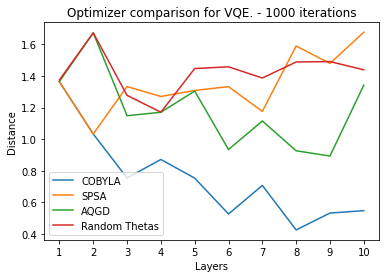

In [12]:
# Evaluating all optimizers

x_axis = list(range(1, L+1))
plt.xticks(x_axis)
plt.plot(x_axis, cobyla_results, label="COBYLA")
plt.plot(x_axis, spsa_results, label="SPSA")
plt.plot(x_axis, aqgd_results, label="AQGD")
plt.plot(x_axis, random_results, label="Random Thetas")
plt.title('Optimizer comparison for VQE. - '+ str(ITERATIONS) +" iterations")
plt.legend()
plt.xlabel('Layers')
plt.ylabel('Distance')
plt.savefig('Optimizer_Benchmark_'+ str(time.time()) + '_Iterations_'+str(ITERATIONS)+'_'+ODD_GATES_ROTATION+EVEN_GATES_ROTATION+EVEN_GATES_ENTANGLER+'.png')


## Quick time performance / Benchmark calculation
Because real time is also important!

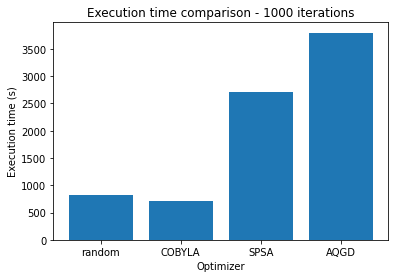

In [13]:
# Plot execution timmes performance
keys = CALCULATION_TIMES.keys()
values = CALCULATION_TIMES.values()

plt.xlabel('Optimizer')
plt.ylabel('Execution time (s)')
plt.title('Execution time comparison - '+ str(ITERATIONS) +" iterations")
plt.bar(keys, values)
plt.savefig('Execution_time_comparison_'+ str(time.time()) + '_Iterations_'+str(ITERATIONS)+'_'+ODD_GATES_ROTATION+EVEN_GATES_ROTATION+EVEN_GATES_ENTANGLER+'.png')

## Bonus question
Try using other gates for the parametrized gates and see what happens.

Luckily we have parametrized the variational circuit, so we can nicely compare the different options. We will focus on COBYLA only since it provided the best results.

Here we iterate and create permutations on both the odd and even blocks and store them in a dictionary. Feel free to change the permutations and run them several times, and then add them into the plot

As expected, the difference in the space exploration happens when we change the rotation on the even gates and odd gates, between RZ's, RX's and RY's. But the entangler blocks making no difference to the final approximation.

In [14]:
cobyla_variational_results = {}

In [15]:
## Trial with COBYLA
ODD_GATES_ROTATION = "RY"
EVEN_GATES_ROTATION = "RZ"
EVEN_GATES_ENTANGLER = "CX"

cobyla_variational_results["COBYLA_RY_RZ_CX"] = []
optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_variational_results["COBYLA_RY_RZ_CX"].append(ret[1])

Layers:  1 | Distance:  1.253729612604163
Layers:  2 | Distance:  1.0203597735356693
Layers:  3 | Distance:  1.011567465941206
Layers:  4 | Distance:  0.8463526644281458
Layers:  5 | Distance:  0.7854534970003645
Layers:  6 | Distance:  0.7188519009111748
Layers:  7 | Distance:  0.5347779352753678
Layers:  8 | Distance:  0.6495069496498322
Layers:  9 | Distance:  0.5618325948138995
Layers:  10 | Distance:  0.5109184159956845


In [16]:
## Trial with COBYLA
ODD_GATES_ROTATION = "RY"
EVEN_GATES_ROTATION = "RY"
EVEN_GATES_ENTANGLER = "CX"

cobyla_variational_results["COBYLA_RY_RY_CX"] = []

optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_variational_results["COBYLA_RY_RY_CX"].append(ret[1])
    

Layers:  1 | Distance:  1.199455893786476
Layers:  2 | Distance:  1.1991534158658006
Layers:  3 | Distance:  1.169588863486714
Layers:  4 | Distance:  1.1670471603239436
Layers:  5 | Distance:  1.0989511272759427
Layers:  6 | Distance:  1.1045186537385219
Layers:  7 | Distance:  1.0902609896041608
Layers:  8 | Distance:  1.044179634507154
Layers:  9 | Distance:  1.0584156817321526
Layers:  10 | Distance:  1.022526951143255


In [17]:
## Trial with COBYLA
ODD_GATES_ROTATION = "RY"
EVEN_GATES_ROTATION = "RX"
EVEN_GATES_ENTANGLER = "CX"

cobyla_variational_results["COBYLA_RY_RX_CX"] = []

optimizer = COBYLA(maxiter=ITERATIONS, tol=0.0001, rhobeg=0.3)

for layers in list(range(1, L+1)):
    CURRENT_LAYER = layers
    params = THETAS[:CURRENT_LAYER*2]
    bounds = []
    for t in params: bounds.append((0, 2*np.pi))

    ret = optimizer.optimize(num_vars=layers*2, 
                             objective_function=objective_function, 
                             initial_point=params,
                             variable_bounds=bounds)
    psi_theta = run_circuit(ret[0])
    print("Layers: ",layers,"| Distance: ",ret[1])
    cobyla_variational_results["COBYLA_RY_RX_CX"].append(ret[1])
    

Layers:  1 | Distance:  1.1083130347383872
Layers:  2 | Distance:  0.9102716167095452
Layers:  3 | Distance:  0.7982714875366811
Layers:  4 | Distance:  0.7853279357648868
Layers:  5 | Distance:  0.83147350891529
Layers:  6 | Distance:  0.7539915216625879
Layers:  7 | Distance:  0.7666986537695754
Layers:  8 | Distance:  0.6249844423678086
Layers:  9 | Distance:  0.6527716165522797
Layers:  10 | Distance:  0.7140936151683431


In [18]:
for i in cobyla_variational_results:
    print(i)
    print(cobyla_variational_results[i])

COBYLA_RY_RZ_CX
[1.253729612604163, 1.0203597735356693, 1.011567465941206, 0.8463526644281458, 0.7854534970003645, 0.7188519009111748, 0.5347779352753678, 0.6495069496498322, 0.5618325948138995, 0.5109184159956845]
COBYLA_RY_RY_CX
[1.199455893786476, 1.1991534158658006, 1.169588863486714, 1.1670471603239436, 1.0989511272759427, 1.1045186537385219, 1.0902609896041608, 1.044179634507154, 1.0584156817321526, 1.022526951143255]
COBYLA_RY_RX_CX
[1.1083130347383872, 0.9102716167095452, 0.7982714875366811, 0.7853279357648868, 0.83147350891529, 0.7539915216625879, 0.7666986537695754, 0.6249844423678086, 0.6527716165522797, 0.7140936151683431]


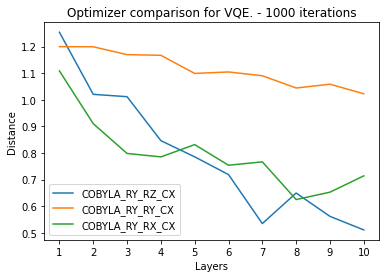

In [19]:
# Evaluating all optimizers

x_axis = list(range(1, L+1))
plt.xticks(x_axis)
for combination in cobyla_variational_results:
    plt.plot(x_axis, cobyla_variational_results[combination], label=combination)
plt.title('Optimizer comparison for VQE. - '+ str(ITERATIONS) +" iterations")
plt.legend()
plt.xlabel('Layers')
plt.ylabel('Distance')
plt.savefig('COBYLA_Benchmark_Gates_'+ str(time.time()) + '_Iterations_'+str(ITERATIONS)+'.png')


## Conclusions

After launching the experiments several times and with different iterations and hyperparameters we conclude that COBYLA provides the closest approximation to the initial random vector.

The chosen Ansatz could be potentially optimized, as well as fine tunning the parameters. In some cases we are overshooting and producing wrong results just because of the choice of said hyperparameters. Further exploration can be done to use different optimizers and evaluate their performance.

In general, we see that for most optimizers there is a threshold in the number of layers (3-4) after which more gates don't bring additional marginal benefit on the approximation. Results differ depending on the original vector and the initial random parameters but this threshold seems to hold for around 1000 iterations each.

It is interesting to note from the variation of rotations, that the best combination for the COBYLA is when we apply RY and RZ rotations and CX entangler. One potential reason could be that with the three rotations we can explore the hamiltonian space completely.